In [10]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.feature_selection import RFECV

In [2]:
data = pd.read_csv("diabetes_data.csv")

In [3]:
variabel_numerik = data.columns.difference(['BMI', 'MentHlth', 'PhysHlth'])
data[variabel_numerik] = data[variabel_numerik].astype('category')
data[variabel_numerik] = data[variabel_numerik].apply(lambda x: x.cat.codes)

In [4]:
X = data.drop(["Diabetes"], axis = 1)
y = data["Diabetes"]

In [5]:
# Calculate information gain
ig = mutual_info_classif(X, y)

# Create dictionary to store information gain values
ig_dict = {}
for i in range(len(X.columns)):
    ig_dict[X.columns[i]] = ig[i]

# Sort features by information gain in descending order
ig_dict_sorted = dict(sorted(ig_dict.items(), key=lambda item: item[1], reverse=True))

# Select the top n features
n = 8
selected_features = list(ig_dict_sorted.keys())[:n]

X_infgain = X[selected_features]

print('Selected Features:')
print(selected_features)


Selected Features:
['GenHlth', 'HighBP', 'BMI', 'HighChol', 'Age', 'DiffWalk', 'HeartDiseaseorAttack', 'PhysHlth']


In [12]:
X_infgain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GenHlth               70692 non-null  int8   
 1   HighBP                70692 non-null  int8   
 2   BMI                   70692 non-null  float64
 3   HighChol              70692 non-null  int8   
 4   Age                   70692 non-null  int8   
 5   DiffWalk              70692 non-null  int8   
 6   HeartDiseaseorAttack  70692 non-null  int8   
 7   PhysHlth              70692 non-null  float64
dtypes: float64(2), int8(6)
memory usage: 1.5 MB


In [13]:
X_float64 = X_infgain.select_dtypes(include=['float64'])

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


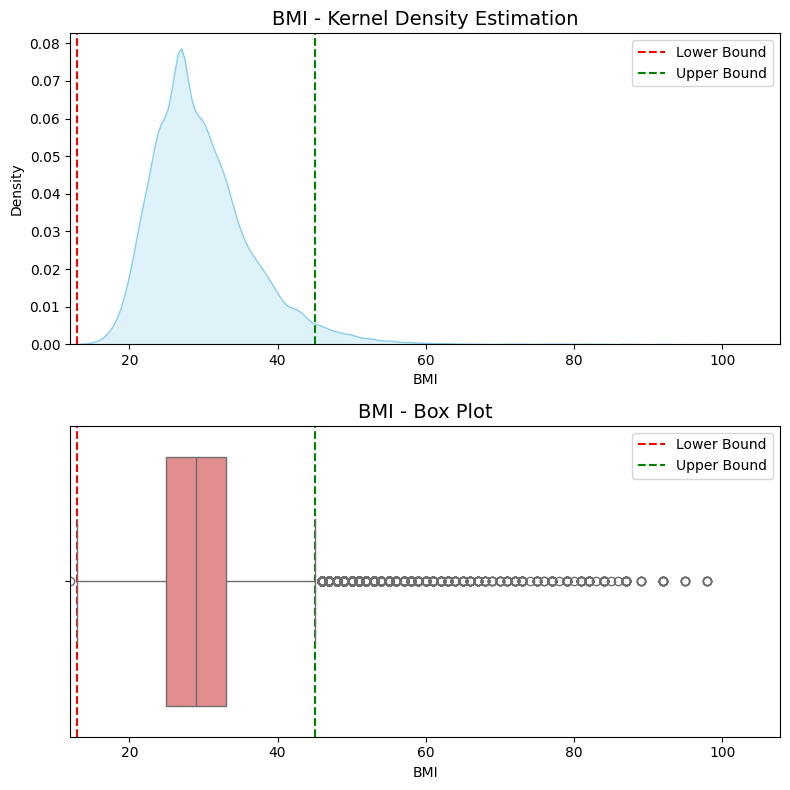

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


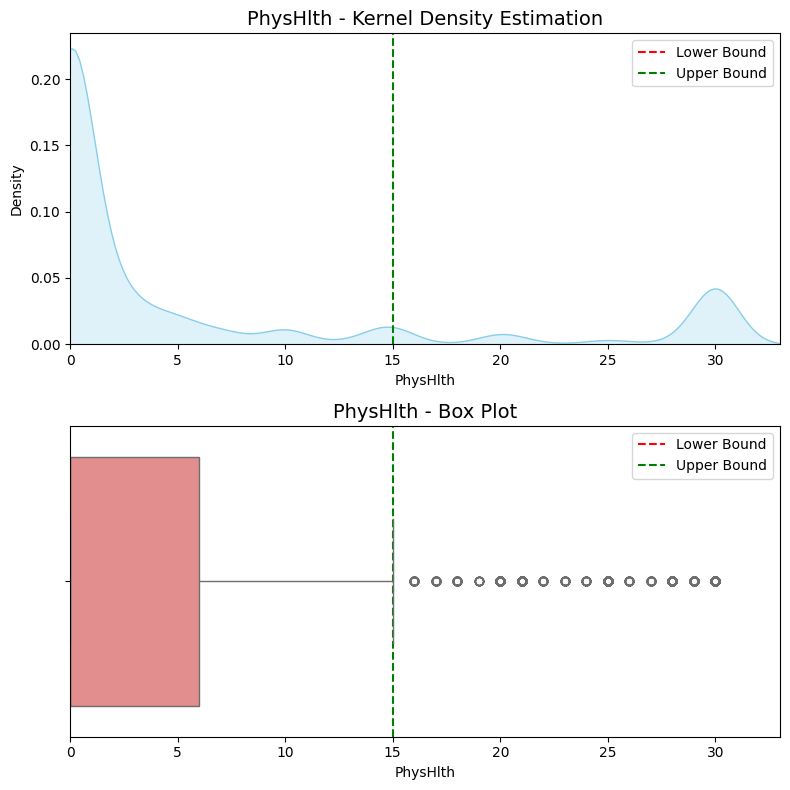

In [14]:
for feature in X_float64.columns:
    q25, q75 = np.percentile(X_float64[feature], [25, 75])
    iqr = q75 - q25
    lower_bound = q25 - iqr * 1.5
    upper_bound = q75 + iqr * 1.5

    plt.figure(figsize=(8, 8))

    # Kernel Density Estimation Plot
    plt.subplot(211)
    plt.xlim(X_float64[feature].min(), X_float64[feature].max() * 1.1)
    plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound')
    sns.kdeplot(X_float64[feature], fill=True, color='skyblue')
    plt.legend()
    plt.title(f'{feature} - Kernel Density Estimation', fontsize=14)
    plt.grid(False)  # Menghapus grid dari KDE plot

    # Box Plot
    plt.subplot(212)
    plt.xlim(X_float64[feature].min(), X_float64[feature].max() * 1.1)
    plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound')
    sns.boxplot(x=X_float64[feature], color='lightcoral')
    plt.legend()
    plt.title(f'{feature} - Box Plot', fontsize=14)
    plt.grid(False)  
    
    plt.tight_layout() 
    plt.show()

In [15]:
##Menghapus outlier
for i in X_float64.keys():
    q25, q75 = np.percentile(X_float64[i], [25,75])
    iqr = q75 - q25
    
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    
    X_float64.loc[data[i] < lower_bound, i] = lower_bound
    X_float64.loc[data[i] > upper_bound, i] = upper_bound

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib

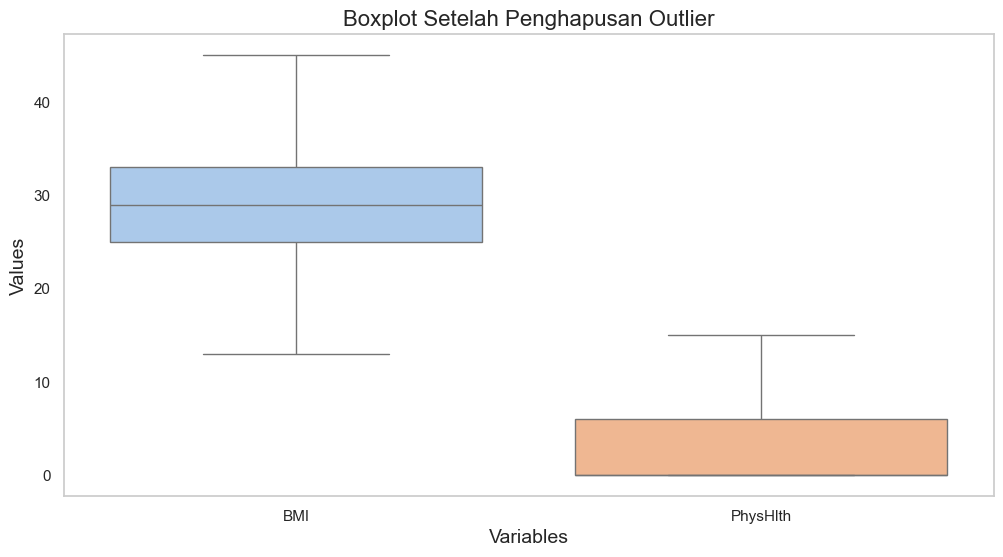

In [16]:
##Mengecek outlier setelah dihapus
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))  

boxplot = sns.boxplot(data=X_float64, palette='pastel', showfliers=False)
plt.title('Boxplot Setelah Penghapusan Outlier', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.grid(False)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_float64, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
y_train.value_counts()

Diabetes
1    28277
0    28276
Name: count, dtype: int64

In [20]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# define the model
clf= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      )

X_train_np = X_train.values
X_test_np = X_test.values

# Fit the model using NumPy arrays
clf.fit(
    X_train_np, y_train,
    eval_set=[(X_train_np, y_train), (X_test_np, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['auc', 'balanced_accuracy'],
    max_epochs=200, patience=60,
    batch_size=512, virtual_batch_size=512,
    num_workers=0, weights=1, drop_last=False
)

epoch 0  | loss: 0.62596 | train_auc: 0.70434 | train_balanced_accuracy: 0.51936 | test_auc: 0.70592 | test_balanced_accuracy: 0.51881 |  0:00:07s
epoch 1  | loss: 0.62275 | train_auc: 0.71142 | train_balanced_accuracy: 0.64253 | test_auc: 0.71174 | test_balanced_accuracy: 0.64235 |  0:00:14s
epoch 2  | loss: 0.62306 | train_auc: 0.71422 | train_balanced_accuracy: 0.65625 | test_auc: 0.71417 | test_balanced_accuracy: 0.65769 |  0:00:21s
epoch 3  | loss: 0.6229  | train_auc: 0.71393 | train_balanced_accuracy: 0.65415 | test_auc: 0.7147  | test_balanced_accuracy: 0.65443 |  0:00:27s
epoch 4  | loss: 0.62152 | train_auc: 0.71471 | train_balanced_accuracy: 0.65464 | test_auc: 0.71429 | test_balanced_accuracy: 0.6562  |  0:00:33s
epoch 5  | loss: 0.62256 | train_auc: 0.71466 | train_balanced_accuracy: 0.6556  | test_auc: 0.71486 | test_balanced_accuracy: 0.6562  |  0:00:40s
epoch 6  | loss: 0.61855 | train_auc: 0.7141  | train_balanced_accuracy: 0.6556  | test_auc: 0.71414 | test_balanced_a

KeyboardInterrupt: 

In [21]:
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, make_scorer
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def xgb_cv(n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree):
    # Define the model with the current parameters
    model = XGBClassifier(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=int(min_child_weight),
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    
    # Perform cross-validation and calculate recall (macro average) as the score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(recall_score, average='macro'))
    return cv_scores.mean()

# Define the parameter space for Bayesian Optimization
param_bounds = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'gamma': (0, 0.5),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

# Initialize the Bayesian Optimizer
optimizer = BayesianOptimization(
    f=xgb_cv,         # Function to optimize
    pbounds=param_bounds,  # Parameter bounds
    random_state=42,
    verbose=2
)

# Run the optimization
optimizer.maximize(init_points=10, n_iter=100)

# Extract the best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

print("Best parameters found: ", best_params)

# Train the model with the best parameters
best_xgb = XGBClassifier(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)

# Make predictions and evaluate
best_xgb_preds = best_xgb.predict(X_test)
print(classification_report(y_test, best_xgb_preds))

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.6561    | 0.7498    | 0.4754    | 0.2223    | 7.191     | 2.404     | 162.4     | 0.6232    |
| 2         | 0.6558    | 0.9465    | 0.3006    | 0.2153    | 3.144     | 9.729     | 433.0     | 0.6849    |
| 3         | 0.6562    | 0.6727    | 0.0917    | 0.09823   | 6.673     | 4.888     | 216.5     | 0.8447    |
| 4         | 0.6562    | 0.6558    | 0.1461    | 0.1162    | 6.192     | 8.067     | 179.9     | 0.8057    |
| 5         | 0.6561    | 0.837     | 0.02323   | 0.1862    | 4.194     | 1.585     | 479.6     | 0.9863    |
| 6         | 0.6563    | 0.9234    | 0.1523    | 0.03832   | 7.79      | 4.961     | 148.8     | 0.7981    |
| 7         | 0.6563    | 0.6138    | 0.4547    | 0.08505   | 7.638     | 3.805     | 308.0     | 0.8187    |
| 8       

In [22]:
# Initialize the XGBoost classifier
X_train = X_train.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)
X_test = X_test.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)

xg = XGBClassifier(n_estimators=350)

# Fit the model
xg.fit(X_train, y_train)

# Make predictions
xg_preds = xg.predict(X_test)

# Print classification report
print(classification_report(y_test, xg_preds))


              precision    recall  f1-score   support

           0       0.66      0.65      0.65      7070
           1       0.65      0.66      0.66      7069

    accuracy                           0.65     14139
   macro avg       0.65      0.65      0.65     14139
weighted avg       0.65      0.65      0.65     14139



In [23]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Initialize the LightGBM classifier
lgbm = LGBMClassifier(n_estimators=350, random_state=42)

# Fit the model
lgbm.fit(X_train, y_train)

# Make predictions
lgbm_preds = lgbm.predict(X_test)

# Print classification report
print("LightGBM Classification Report:")
print(classification_report(y_test, lgbm_preds))

[LightGBM] [Info] Number of positive: 28277, number of negative: 28276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 56553, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500009 -> initscore=0.000035
[LightGBM] [Info] Start training from score 0.000035
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65      7070
           1       0.65      0.66      0.66      7069

    accuracy                           0.65     14139
   macro avg       0.66      0.65      0.65     14139
weighted avg       0.66      0.65      0.65     14139



In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier  # A simple base estimator for AdaBoost
from sklearn.metrics import classification_report

# Initialize the AdaBoost classifier with a decision tree as the base estimator
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),  # A weak classifier, can be adjusted
    n_estimators=350,
    random_state=42
)

# Fit the model
ada.fit(X_train, y_train)

# Make predictions
ada_preds = ada.predict(X_test)

# Print classification report
print("AdaBoost Classification Report:")
print(classification_report(y_test, ada_preds))


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67      7070
           1       0.67      0.62      0.65      7069

    accuracy                           0.66     14139
   macro avg       0.66      0.66      0.66     14139
weighted avg       0.66      0.66      0.66     14139

